In [1]:
import os
import re
import json
import copy
import collections
import numpy as np
import pandas as pd
import hazm
from cleantext import clean

In [2]:
cat_df = pd.read_csv('categories.csv')
com_df = pd.read_csv('comments.csv')
products_df = pd.read_csv('products.csv')

## Categories exploration

In [3]:
cat_df.head()

,vid,id,title_fa,code,parent_cat,done
0,2,2,تبلت و کتابخوان,tablet-ebook-reader,5966,t
1,3,3,لپ تاپ,laptop,5966,t
2,4,6,دوربین,camera,5966,t
3,5,4,کامپیوتر و تجهیزات جانبی,computer-parts,5966,t
4,6,5,ماشین های اداری,office-machines,5966,t


In [4]:
cat_df = cat_df.drop(columns=['vid','id','parent_cat'])

In [5]:
cat_df.head()
print(f"Number of unique categories: {cat_df['title_fa'].nunique()}")
print(f"Number of unique cat codes: {cat_df['code'].nunique()}")
# print(cat_df['title_fa'].apply(lambda t: len(hazm.word_tokenize(t))))
cat_df.info()

Number of unique categories: 95
Number of unique cat codes: 95
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title_fa  96 non-null     object
 1   code      96 non-null     object
 2   done      96 non-null     object
dtypes: object(3)
memory usage: 2.4+ KB


## Comments exploration

In [6]:
com_df.head()

,vid,id,product_id,body,rate,done
0,3,43838571,6909055,اصلا به بلوتوث وصل نمیشه نمیشه ساعتش را تنظیم ...,1.0,f
1,6,43831255,6909055,یه چیزی فرستادین که فقط روشن میشه و بعد چند ثا...,1.0,f
2,8,43826435,6909055,سلام یکی از دکمه هاش کار نمی کنه,1.0,f
3,9,43822870,6909055,کالای نورد قبولی هستش؛ نسبت به قیمت واقعا عالی...,0.0,f
4,10,43816708,6909055,عالیییی بود فقط اول کار شارژ نداشت,5.0,f


In [51]:
print(f"original rating values: {com_df['rate'].unique()}")

com_df['new_rate'] = com_df['rate'].apply(lambda rate: round(rate))
print(f"new rating values: {sorted(com_df['new_rate'].unique())}")

original rating values: [1.   0.   5.   4.   3.   2.   1.9  1.2  4.3  4.1  4.5  4.6  3.7  3.8
 4.8  4.65 4.15 1.95 1.6  2.1  2.9  1.1  2.4  4.7  4.4  4.25 4.75 3.2
 3.6  2.25 3.3  1.4  1.25 2.3  4.85 4.35 3.15 1.8  2.5  4.05 0.7  3.5
 4.63 3.75 4.88 4.2  2.85 3.65 3.35 2.7  2.65 2.6  3.4  2.8  0.25 2.75
 4.45 2.2  3.45 1.85 2.64 1.75 3.9  3.55 4.9  4.55 0.6  1.05 0.5 ]
new rating values: [0, 1, 2, 3, 4, 5]


In [8]:
com_df['comment_word_count'] = com_df['body'].apply(lambda t: len(hazm.word_tokenize(t)))
print(f"comments min and max length: {com_df['comment_word_count'].min()}, {com_df['comment_word_count'].max()}")

comments min and max length: 1, 1125


<AxesSubplot:title={'center':'Comments word count distribution'}, xlabel='comment_word_count', ylabel='count'>

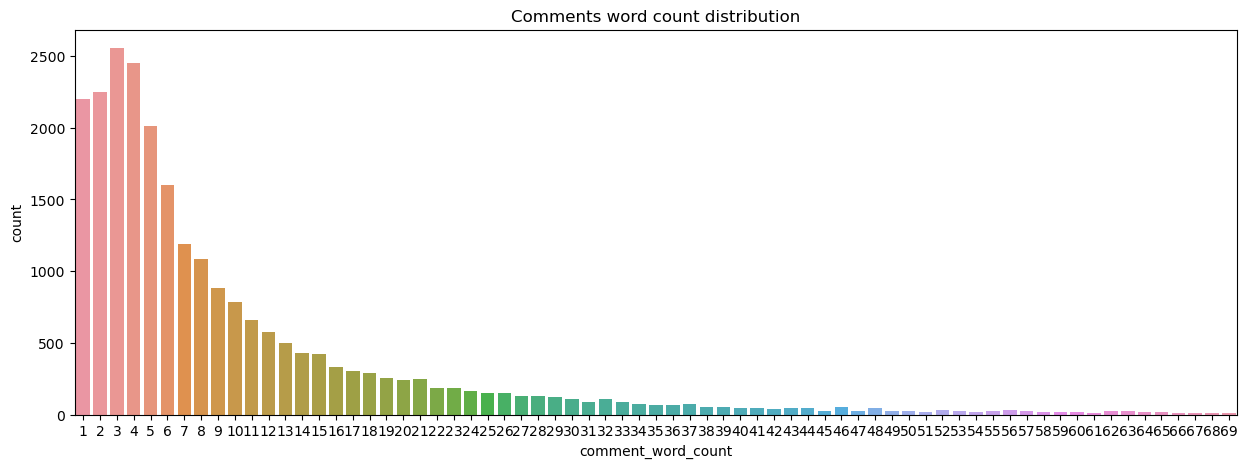

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.title('Comments word count distribution')
dt = com_df.loc[com_df['comment_word_count']<70]
sns.countplot(x=dt['comment_word_count'])

<AxesSubplot:title={'center':'Rate count distribution'}, xlabel='new_rate'>

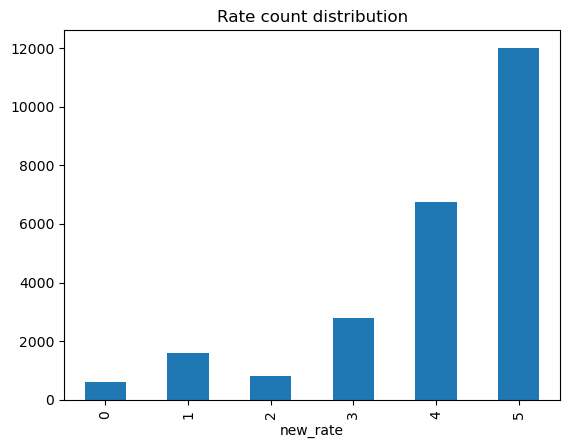

In [86]:
plt.title('Rate count distribution')
groupby_rate = com_df.groupby('new_rate')['new_rate'].count()
groupby_rate.plot.bar()

## Products exploration

In [87]:
products_df.head()

,vid,id,cat_id,title_fa,rate,views,done
0,13,4291430,5966,مجموعه کنسول بازی سونی مدل PlayStation 5 Drive...,92,225,t
1,5,5086666,5966,هندزفری بلوتوثی مدل inpods 12,78,26888,t
2,14,5856710,5966,هدفون بلوتوثی کیو سی وای مدل T13 TWS,88,6221,t
3,11,4313121,5966,ساعت هوشمند مدل HW16,68,2543,t
4,21,6997456,2,تبلت اپل مدل iPad Mini 6th Generation 8.3 inch...,88,63,t


In [112]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   vid       1615 non-null   int64 
 1   id        1615 non-null   int64 
 2   cat_id    1615 non-null   int64 
 3   title_fa  1615 non-null   object
 4   rate      1615 non-null   int64 
 5   views     1615 non-null   int64 
 6   done      1615 non-null   object
dtypes: int64(5), object(2)
memory usage: 88.4+ KB


In [91]:
print(f"original rating values: {products_df['rate'].unique()}")
print(f"original rating count: {products_df['rate'].nunique()}")

original rating values: [ 92  78  88  68  90  84  86  70  82  80 100  60  38  74  94  76  62  54
   0  96  66  72  56  64  20  58  40  30  52  50  46  48]
original rating count: 32


<AxesSubplot:title={'center':'Products rate count distribution'}, xlabel='rate'>

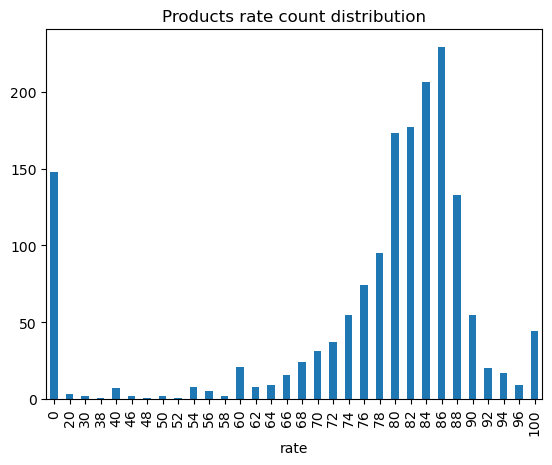

In [113]:
plt.title('Products rate count distribution')
groupby_rate2 = products_df.groupby('rate')['rate'].count()
groupby_rate2.plot.bar()

Views min and max:(0, 26888)


([], [])

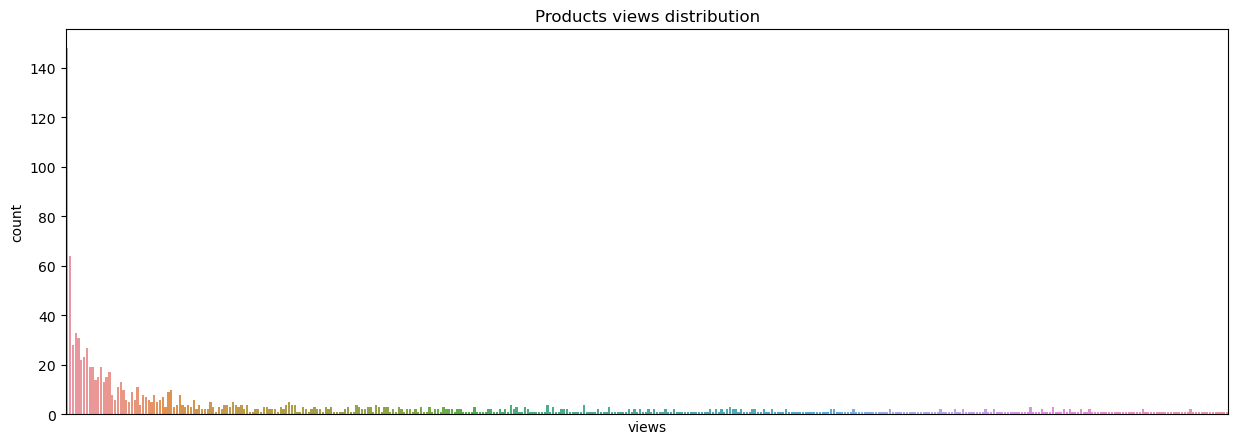

In [114]:
plt.figure(figsize=(15, 5))
plt.title('Products views distribution')
print(f"Views min and max:{products_df['views'].min(), products_df['views'].max()}")
dt = products_df.loc[products_df['views']<1000]
sns.countplot(x=dt['views'])
plt.xticks([])